In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass

Disease = candidate_subclass('Disease', ['disease'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates').one()
print len(train)
dev = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates').one()
print len(dev)

28087
27896


In [3]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

L_gold_train = label_manager.load(session, train, "CDR Training Label Set")
print L_gold_train.shape
L_gold_dev = label_manager.load(session, dev, "CDR Development Label Set")
print L_gold_dev.shape

(28087, 1)
(27896, 1)


# Load `L_train` and `L_dev`

In [4]:
%%time
from snorkel.annotations import merge_annotations
from utils import binarize_LF_matrix, get_binarized_score

L_TRAIN_BLOCKS = ['1', '2', '3', '4.1', '4 T2', '4 N', '5', '6']
L_DEV_BLOCKS   = ['1', '2', '3.1', '4', '4 T2', '4 N', '5', '6']

L_train_blocks = [label_manager.load(session, train, 'LF Training Labels %s' % lfn) for lfn in L_TRAIN_BLOCKS]
L_dev_blocks   = [label_manager.load(session, dev, 'LF Development Labels %s' % lfn) for lfn in L_DEV_BLOCKS]

L_train   = merge_annotations(L_train_blocks)
L_train_b = binarize_LF_matrix(L_train)
L_dev     = merge_annotations(L_dev_blocks)
L_dev_b   = binarize_LF_matrix(L_dev)
print L_train.shape
print L_dev.shape

(28087, 1645)
(27896, 1557)
CPU times: user 52 s, sys: 1.17 s, total: 53.1 s
Wall time: 52.9 s


# Load `F_train` and `F_dev`

In [5]:
%%time
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()

F_train = feature_manager.load(session, train, 'Train Features')
F_dev   = feature_manager.load(session, dev, 'Train Features')
print F_train.shape
print F_dev.shape

(28087, 69885)
(27896, 69885)
CPU times: user 4min 42s, sys: 3.74 s, total: 4min 45s
Wall time: 4min 45s


# Load canonical & secondary dictionaries

In [6]:
cd = load(open('cd.pkl', 'rb'))

# Setup 1: Direct EN

# Setup 1.i: Exact Match

In this first setup, we simply try to do exact matching on noun phrases

In [7]:
correct   = 0
predicted = 0
total_pos = 0
for i,c in enumerate(dev):
    if L_gold_dev[i,0] > 0:
        total_pos += 1
    
    # Check for exact *positive* matches to the canonical dictionary
    p    = c.disease.get_span().lower()
    sids = cd.term_to_sids[p]
    cids = set([cd.sid_to_cid[sid] for sid in sids if sid in cd.sid_to_cid])
    if len(cids) > 0:
        predicted += 1
        cid = list(cids)[0]
        if cid == L_gold_dev[i,0]:
            correct += 1

prec   = correct / float(predicted)
recall = correct / float(total_pos)

print "P:\t", prec
print "R:\t", recall
print "F1:\t", (2*prec*recall) / (prec+recall)

P:	0.825947334618
R:	0.323440643863
F1:	0.464847279957


# Setup 1.ii: TF-IDF

We tune the accept threshold on the training set

In [8]:
%%time
from entity_norm import CanonDictVectorizer 

# Create a vectorizer based around this 
cd_vectorizer = CanonDictVectorizer(cd.term_to_sids, other_phrases=[])

# Vectorize the dictionary
D_pos   = cd_vectorizer.vectorize_phrases(cd.pos_terms)
D_pos_t = D_pos.T
D_pos_t

|V| = 272295
CPU times: user 1min 19s, sys: 1.34 s, total: 1min 20s
Wall time: 1min 19s


In [9]:
def get_pos_vector_matches(candidates):
    best_match = defaultdict(lambda : (0.0, -1))
    for c in candidates:
        p  = c.disease.get_span().lower()
        cx = cd_vectorizer.vectorize_phrases([p])
        m  = cx * D_pos_t
        m  = m.tocoo()
        for i, s in enumerate(m.data):
            j    = m.col[i]
            t    = cd.pos_terms[j]
            sids = cd.term_to_sids[t]
            cid  = list(set([cd.sid_to_cid[sid] for sid in sids if sid in cd.sid_to_cid]))[0]
            if s > best_match[c.id][0]:
                best_match[c.id] = (s, cid)
    return best_match

In [10]:
%time best_match = get_pos_vector_matches(train)

CPU times: user 2min 46s, sys: 2.74 s, total: 2min 49s
Wall time: 2min 49s


(array([  105.,   232.,   983.,  1938.,  2960.,  3814.,  2730.,  2432.,
         1170.,  2194.]),
 array([ 0.02316691,  0.12085022,  0.21853353,  0.31621683,  0.41390014,
         0.51158345,  0.60926676,  0.70695007,  0.80463338,  0.90231669,  1.        ]),
 <a list of 10 Patch objects>)

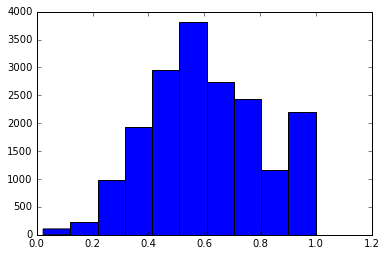

In [11]:
plt.hist([x[0] for x in best_match.values()])

In [12]:
N_pos_train = sum([1 for i in range(L_gold_train.shape[0]) if L_gold_train[i,0] > 0])
N_pos_train

3870

In [13]:
GRID = xrange(0, 20)
f1s  = []

# Grid search over threshold using training set labels
for t in GRID:
    thresh = 0.05 * t
    
    correct   = 0
    predicted = 0
    for i,c in enumerate(train):
        s, cid = best_match[c.id]
        if s > thresh:
            predicted += 1
            if cid == L_gold_train[i,0]:
                correct += 1
    
    prec   = correct / float(predicted)
    recall = correct / float(N_pos_train)
    f1     = (2*prec*recall) / (prec+recall)
    f1s.append(f1)

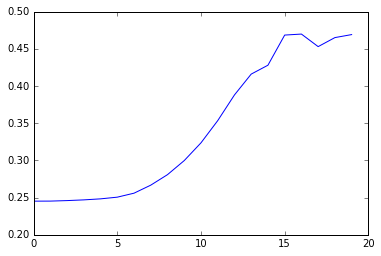

In [14]:
plt.plot(GRID, f1s)

In [ ]:
THRESH = GRID[np.argmax(f1s)]*0.05

In [ ]:
%time best_match = get_pos_vector_matches(dev)

In [ ]:
N_pos_dev = sum([1 for i in range(L_gold_dev.shape[0]) if L_gold_dev[i,0] > 0])
correct   = 0
predicted = 0
for i,c in enumerate(dev):
    s, cid = best_match[c.id]
    if s > THRESH:
        predicted += 1
        if cid == L_gold_dev[i,0]:
            correct += 1
    
prec   = correct / float(predicted)
recall = correct / float(N_pos_dev)
f1     = (2*prec*recall) / (prec+recall)
print "P:\t", prec
print "R:\t", recall
print "F1:\t", f1

# Setup 1.iii: Using the Gen. Model directly

### Using the multinomial version

In [ ]:
from scipy.sparse import lil_matrix

N, M        = L_dev.shape
mn_maps     = []
mn_inv_maps = []
nz_idxs     = []
Xs          = []
for i in range(N):
    nz = L_dev.getrow(i).nonzero()[1]
    if len(nz) > 0:
        nz_idxs.append(i)
    
        # Construct the map from CID -> column index, and reverse
        mn_map     = {}
        mn_inv_map = []
        for j in nz:
            label = L_dev[i,j]
            if label not in mn_map:
                mn_map[label] = len(mn_map)
                mn_inv_map.append(label)
        mn_maps.append(mn_map)
        mn_inv_maps.append(mn_inv_map)
    
        # Construct the candidate label matrix
        X = np.zeros((M, len(mn_map)))
        for j in nz:
            k = mn_map[L_dev[i,j]]
            X[j, k] = 1
        Xs.append(X)

In [ ]:
from snorkel.learning.learning_mn import LogReg

gen_model = LogReg()
gen_model.train(Xs, n_iter=100, rate=1e-2, w0=np.ones(M))

In [ ]:
marginals = gen_model.marginals(Xs)

In [ ]:
predicted = 0
correct   = 0
for i,m in enumerate(marginals):
    cid = mn_inv_maps[i][np.argmax(m)]
    if cid > 0:
        predicted += 1
        if cid == L_gold_dev[nz_idxs][i,0]:
            correct += 1
            
prec   = correct / float(predicted)
recall = correct / float(N_pos_dev)

print "P:\t", prec
print "R:\t", recall
print "F1:\t", (2*prec*recall) / (prec+recall)

# Setup 1.iv: DP -> SSI

In [ ]:
%%time
# Vectorize the train & dev sets
X_train = cd_vectorizer.vectorize([c.disease.get_span().lower() for c in train])
X_dev   = cd_vectorizer.vectorize([c.disease.get_span().lower() for c in dev])

In [ ]:
from entity_norm import SSIModel

model = SSIModel(D, cids)